In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import EMGFeatureExtraction


In [2]:
random.seed(101)

# prepare data
datasets_path = 'data/gestures-9/'
datasets = []
for dataset_name in list(os.walk(datasets_path))[0][1]:
    dataset_path = datasets_path + dataset_name
    print(dataset_path)
    session_names = list(os.walk(dataset_path))[0][1]
    sessions = []
    for session_name in session_names:
        current_session = os.path.join(dataset_path, session_name)
        print(current_session)
        sessions.append(EMGFeatureExtraction.read_emg(current_session))
    datasets.append(sessions)
    print()

preprocessed_datasets = []
for dataset in datasets:
    preprocessed_sessions = []
    for session in dataset:
        window_samples = EMGFeatureExtraction.samples_num_in_window(200, 200)
        session_win = EMGFeatureExtraction.emg_data_windowing(session, window_samples)

        session_X = session_win[:,:-1]
        session_y = session_win[:,-1].astype('int')

#         session_features_X = calculate_features(session_X, 8, True)
        # Concatenate X and y
        session_features = np.c_[session_X, session_y]
        preprocessed_sessions.append(session_features)
    preprocessed_datasets.append(preprocessed_sessions)

data/gestures-9/p001
data/gestures-9/p001\session1
input shape (2250, 65)
result shape:  (18000, 9)
data/gestures-9/p001\session2
input shape (2250, 65)
result shape:  (18000, 9)
data/gestures-9/p001\session3
input shape (2250, 65)
result shape:  (18000, 9)

data/gestures-9/p002
data/gestures-9/p002\session1
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p002\session2
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p002\session3
input shape (2251, 65)
result shape:  (18008, 9)

data/gestures-9/p003
data/gestures-9/p003\session1
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p003\session2
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p003\session3
input shape (2251, 65)
result shape:  (18008, 9)



In [3]:
channels_num = 8
X_sessions_spec = []
y_sessions = []
for session in preprocessed_datasets[0]:
    X = session[:,:-1]
    y = session[:,-1]
    print(X.shape, y.shape)
    
    X_spec = EMGFeatureExtraction.spectrogram(X, channels_num, 200, npserseg=21, noverlap=18)
    print(X_spec.shape)
    
    X_sessions_spec.append(X_spec)
    y_sessions.append(y)
    
X_train = np.concatenate((X_sessions_spec[0], X_sessions_spec[1]), axis=0)
y_train = np.concatenate((y_sessions[0], y_sessions[1]), axis=0)
X_test = X_sessions_spec[2]
y_test = y_sessions[2]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(450, 320) (450,)
(450, 10, 7, 8)
(450, 320) (450,)
(450, 10, 7, 8)
(450, 320) (450,)
(450, 10, 7, 8)
(900, 10, 7, 8)
(900,)
(450, 10, 7, 8)
(450,)


In [4]:
X_train = X_train.astype(complex).real
X_test = X_test.astype(complex).real

In [5]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(16, (2, 2), input_shape=(10, 7, 8), use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(32, (2, 2), use_bias=False))
model.add(layers.BatchNormalization())
model.add(Activation("relu"))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(32, use_bias=False))
model.add(layers.BatchNormalization())
model.add(Activation("relu"))
model.add(layers.Dense(9, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 6, 16)          512       
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 6, 16)          64        
_________________________________________________________________
activation (Activation)      (None, 9, 6, 16)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 3, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 3, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 2, 32)          2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 2, 32)          1

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=0)

450/450 - 0s - loss: 1.6320 - acc: 0.7400


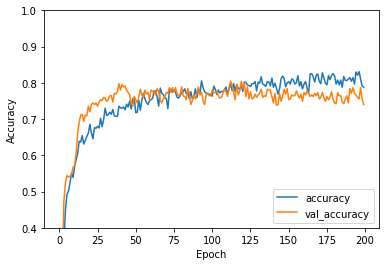

In [8]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

In [9]:
print(test_acc)

0.74
